Mapping Network

In [55]:
import torch 
from torch import nn 

class Mapping_Network(nn.Module):
    def __init__(self , z_dim , w_dim):
        super(Mapping_Network , self).__init__()
        self.mapping = nn.Sequential(
            nn.Linear(z_dim , w_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(w_dim , w_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(w_dim , w_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(w_dim , w_dim),
            nn.LeakyReLU(0.2)
            )

    def forward(self , z):
        return self.mapping(z)

Noise Injection

In [56]:
class Inject_Noise(nn.Module):
    def __init__(self , channels):
        super(Inject_Noise , self).__init__()
        self.weight = nn.Parameter(torch.zeros(1,channels ,  1 , 1))

    def forward(self , x):
        noise = torch.randn((x.shape[0], 1 , x.shape[2] , x.shape[3]) ,device = x.device )
        return x + self.weight * noise

AdaIN

In [57]:
class AdaIN( nn.Module):
    def __init__(self , channels , x_dim):
        super(AdaIN , self).__init__()
        self.Instnorm = nn.InstanceNorm2d(channels)
        self.style_scale =  nn.Linear(x_dim , channels)
        self.style_bias = nn.Linear(x_dim , channels)

    def forward(self , x, w):
        x = self.Instnorm(x)
        scale =  self.style_scale(w).unsqueeze(2).unsqueeze(3)
        bias = self.style_bias(w).unsqueeze(2).unsqueeze(3)
        return x *scale + bias

Style Block

In [58]:
class Style_Block(nn.Module):
    def __init__(self , in_channels , out_channels , w_dim , upsample = True):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor = 2) if upsample else None
        self.conv = nn.Conv2d( in_channels , out_channels , kernel_size = 3 , padding = 1)
        self.noise = Inject_Noise(out_channels)
        self.lrelu = nn.LeakyReLU(0.2)
        self. adain = AdaIN(out_channels , w_dim)

    def forward(self , x, w):
        if self.upsample:
            x = self.upsample(x)
    
        x = self.conv(x)
        x = self.noise(x)
        x = self.lrelu(x)
        x = self.adain(x,w)
        return x



Generator

In [59]:
class Generator(nn.Module):
    def __init__(self , z_dim , w_dim ,img_channels = 1):
        super(Generator , self ).__init__()
        self.mapnet =  Mapping_Network(z_dim , w_dim)
        self.lr_cnst = nn.Parameter(torch.randn(1,512,4,4))

        self.sb1 = Style_Block(512 , 256 , w_dim , upsample =  True)
        self.sb2 = Style_Block(256 , 128 , w_dim , upsample = True)
        self.sb3 = Style_Block(128, 64 ,  w_dim , upsample =  True)

        self.col = nn.Conv2d(64 , img_channels , kernel_size = 1)


    def forward(self , z ):
        w = self.mapnet(z)
        x = self.lr_cnst.repeat(z.shape[0] , 1, 1, 1)
        x = self.sb1(x,w)
        x = self.sb2(x,w)
        x = self.sb3(x,w)

        return torch.tanh(self.col(x))

Discriminator

In [60]:
class Discriminator(nn.Module):
    def __init__(self , img_channels = 1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels , 64 , kernel_size = 3 ,stride = 2, padding = 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64 , 128 , kernel_size = 3 ,stride = 2, padding = 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128 , 256 , kernel_size = 3 ,stride = 2, padding = 1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4 ,1)


        )


    def forward(self , x):
        return self.net(x)

In [66]:
print(len(list(critic.parameters()))) 
# This should be 8 (4 conv/linear layers, each with weight and bias)

8


Gradient Penalty 

In [62]:
def Gradient_Penalty (critc , real , fake , device = 'cpu'):
    BATCH_SIZE ,C , H , W = real.shape
    alpha = torch.rand((BATCH_SIZE , 1, 1, 1)).repeat(1 , C , H , W).to(device)
    interpolated_images = real * alpha +fake * (1-alpha)
    interpolated_images.requires_grad_(True)

    mix_score = critc(interpolated_images)

    gradient = torch.autograd.grad(
        inputs = interpolated_images , 
        outputs = mix_score , 
        grad_outputs = torch.ones_like(mix_score) ,
        create_graph = True ,
        retain_graph = True

    )[0]


    gradient = gradient.view(gradient.shape[0] , -1)
    gradient_norm = gradient.norm(2 , dim = 1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

Training Loop 

In [63]:
import torch.optim as optim 

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
Z_DIM = 512
W_DIM = 512
LAMBDA_GP = 10
BATCH_SIZE = 64
LR = 1e-4

gen = Generator(Z_DIM , W_DIM).to(DEVICE)
critic = Discriminator().to(DEVICE)
opt_gen = optim.Adam(gen.parameters() , lr = LR , betas = (0.0 , 0.99))
opt_critic = optim.Adam(critic.parameters() , lr = LR , betas = (0.0 , 0.99))

def train_step(real):
    real_images = real.to(DEVICE)
    cur_batch_size = real_images.shape[0]

    for _ in range(5):
        noise = torch.randn(cur_batch_size , Z_DIM).to(DEVICE)
        fake_images = gen(noise)
        critic_real = critic(real_images)
        critic_fake = critic(fake_images.detach())
        gp = Gradient_Penalty(critic , real_images , fake_images.detach() , device = DEVICE)
        loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake)) + Lambda_GP * gp

        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

    gen_fake = critic(fake_images)
    loss_gen = -torch.mean(gen_fake)
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()


    return loss_gen.item() , loss_critic.item()


Dataloading and pipeline

In [64]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root="dataset/", train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(50):
    for batch_idx, (real, _) in enumerate(loader):
        loss_c, loss_g = train_step(real)
        
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch}/50] Batch {batch_idx}/{len(loader)} Loss D: {loss_c:.4f}, loss G: {loss_g:.4f}")

Epoch [0/50] Batch 0/938 Loss D: 0.0055, loss G: 8.5647
Epoch [0/50] Batch 100/938 Loss D: 0.6069, loss G: -5.9600
Epoch [0/50] Batch 200/938 Loss D: 8.6193, loss G: -6.6609
Epoch [0/50] Batch 300/938 Loss D: 8.1069, loss G: -8.7349
Epoch [0/50] Batch 400/938 Loss D: 12.5523, loss G: -8.5296
Epoch [0/50] Batch 500/938 Loss D: 21.8382, loss G: -12.0537
Epoch [0/50] Batch 600/938 Loss D: 16.4892, loss G: -12.2607
Epoch [0/50] Batch 700/938 Loss D: -1.5364, loss G: -12.7820
Epoch [0/50] Batch 800/938 Loss D: 6.9173, loss G: -4.3665
Epoch [0/50] Batch 900/938 Loss D: 19.9522, loss G: -4.0234
Epoch [1/50] Batch 0/938 Loss D: 21.5159, loss G: -4.3055
Epoch [1/50] Batch 100/938 Loss D: 15.6575, loss G: -3.6999
Epoch [1/50] Batch 200/938 Loss D: 19.1030, loss G: -4.2587
Epoch [1/50] Batch 300/938 Loss D: 20.9280, loss G: -4.7088
Epoch [1/50] Batch 400/938 Loss D: 33.5932, loss G: -5.4078
Epoch [1/50] Batch 500/938 Loss D: 17.4851, loss G: -3.6215
Epoch [1/50] Batch 600/938 Loss D: 27.9810, los

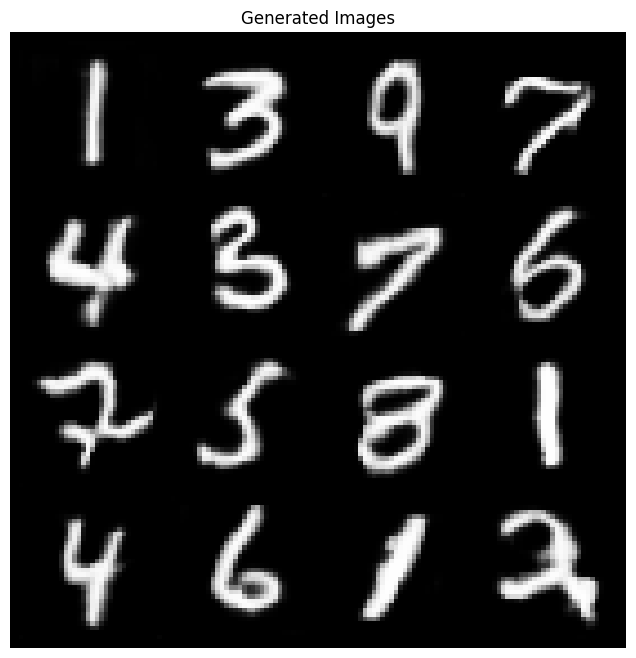

In [65]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

def show_generated_images(generator, num_images=16, z_dim=512, device="cpu"):
    generator.eval() # Set to evaluation mode
    with torch.no_grad():
        # 1. Generate random noise
        noise = torch.randn(num_images, z_dim).to(device)
        
        # 2. Generate images
        fake_images = generator(noise).detach().cpu()
        
        # 3. Create a grid (nrow is images per row)
        grid = vutils.make_grid(fake_images, nrow=4, normalize=True, value_range=(-1, 1))
        
        # 4. Plot using Matplotlib
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title("Generated Images")
        # Permute from (C, H, W) to (H, W, C) for Matplotlib
        plt.imshow(np.transpose(grid, (1, 2, 0)))
        plt.show()

# To use it:
show_generated_images(gen, num_images=16, z_dim=Z_DIM, device=DEVICE)